*This study was conducted for skills demonstration purposes only*

# **Forecasting the UK Construction Sector with Macroeconomic Indicators**
# Section 4. Exploratory Data Analysis (EDA)

In the previous sections, all necessary data was collected, cleaned, formatted, normalized, differentiated and saved as df_q_eda_norm.parquet, df_q_eda_norm_add.parquet, df_q_eda.parquet, df_q_eda_add.parquet and  df_m_model_diff.parquet, df_q_model_diff.parquet. All outliers were processed. In this section all datasets will be analyzed and investigated for dependencies between indicators with data visualization methods.

### 1. Tools and Libraries

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import seaborn as sns
from numpy import arcsinh

### 2.  Auxiliary Functions

In [117]:
# Heatmap plotting function
def plot_correlation_heatmap(corr_matrix, title):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(18, 8))

    # Plot heatmap
    ax = sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        cbar_kws={"label": "Correlation"},
        linewidths=0.5,
        linecolor='gray',
        annot_kws={"color": "black"},
        alpha= 1.0
    )

    # Add vertical group dividers
    for boundary in group_boundaries:
        ax.axvline(x=boundary, color='#555555', linewidth=2)

    # Set background color for x-tick labels
    for i, (start, end) in enumerate(group_ranges):
        for j in range(start, end):
            if j < len(ax.get_xticklabels()):
                ax.get_xticklabels()[j].set_backgroundcolor(group_colors[i])

    # Add group labels above heatmap
    for (start, end), label in zip(group_label_ranges, group_labels):
        x_center = (start + end) / 2
        ax.text(x_center, -0.2, label, ha='center', va='bottom', fontsize=13)

    # Adjust tick spacing and padding
    ax.tick_params(axis='x', pad=5)
    plt.title(title, fontsize=18, pad=60)
    plt.xlabel("Construction Indicators", fontsize=15)
    plt.ylabel("Macroeconomic Indicators", fontsize=15, labelpad=20)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=13)
    plt.tight_layout()
    plt.show()

In [118]:
def create_subplot_trends(df, plots_dict, subtitle):
    """
    Creates subplots for multiple sets of time series data with key event markers.

    Parameters:
    - df: DataFrame with a PeriodIndex (quarterly) or DatetimeIndex, plus event marker columns.
    - plots_dict: {subplot_title: [col_list, label_list, color_list], ...}
    - subtitle: Title for the entire figure.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    # Build a datetime index for plotting
    if isinstance(df.index, pd.PeriodIndex):
        freqstr = df.index.freqstr or ""
        how = "end" if freqstr.startswith("Q") else "start"
        x_index = df.index.to_timestamp(how=how)
    else:
        x_index = pd.to_datetime(df.index)
        how = "end"

    # Helper: get first/last event date as Timestamp (or None)
    def get_event_date(column, first=True):
        if column not in df.columns:
            return None
        idx = df.index[df[column] == 1]
        if len(idx) == 0:
            return None
        raw = idx[0] if first else idx[-1]
        if isinstance(raw, pd.Period):
            return raw.to_timestamp(how=how)
        return pd.to_datetime(raw)

    # Detect event dates
    events = [
        (get_event_date("COVID lockdown"), "COVID Lockdown"),
        (get_event_date("GFC", first=True), "2008 Crisis Start"),
        (get_event_date("GFC", first=False), "2008 Crisis End"),
        (get_event_date("Brexit"), "Brexit Referendum"),
    ]

    # Setup figure and subplots
    n_plots = len(plots_dict)
    fig, axes = plt.subplots(n_plots, 1, figsize=(14, 5 * n_plots), sharex=True)
    if n_plots == 1:
        axes = [axes]

    for ax, (plot_title, (col_list, label_list, color_list)) in zip(axes, plots_dict.items()):
        # Plot series
        for col, label, color in zip(col_list, label_list, color_list):
            ax.plot(x_index, df[col], label=label, color=color)

        # Event markers + labels AT THE TOP of each subplot
        for dt, lbl in events:
            if dt is not None:
                ax.axvline(x=dt, color="red", linestyle="--", linewidth=1, zorder=0)
                ax.annotate(
                    lbl,
                    xy=(dt, 1), xycoords=("data", "axes fraction"),  # top edge of axes
                    xytext=(0, -8), textcoords="offset points",      # nudge inside the plot
                    ha="right", va="top",
                    rotation=45, rotation_mode="anchor",
                    fontsize=9, color="red",
                    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1),
                    annotation_clip=False,
                )

        # Styling
        ax.set_title(plot_title, fontsize=14)
        ax.set_ylabel("Normalized")
        ax.grid(True)
        ax.legend()
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.tick_params(axis="x", rotation=45)

    axes[-1].set_xlabel("Date")
    fig.suptitle(subtitle, fontsize=16, y=0.995)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # leave room for the suptitle
    plt.show()

In [119]:
def create_subplot_new_contr(plots_dict, subtitle):
    """
    Creates vertically stacked area chart subplots with optional line overlays.

    Expected key event columns in each df:
      - 'COVID lockdown'  (1 at event quarter)
      - 'GFC'             (1 over the crisis span; first=Start, last=End)
      - 'Brexit'          (1 at event quarter)
    """

    n_subplots = len(plots_dict)
    fig, axes = plt.subplots(nrows=n_subplots, ncols=1,
                             figsize=(15, 5 * n_subplots), squeeze=False)

    for i, (title, components) in enumerate(plots_dict.items()):
        df = components[0].copy()
        col_area_list = components[1]
        area_label_list = components[2]
        col_line_list  = components[3] if len(components) > 3 else []
        line_label_list = components[4] if len(components) > 4 else []
        line_color_list = components[5] if len(components) > 5 else []

        # ---- Build a datetime index for plotting (handles PeriodIndex) ----
        if isinstance(df.index, pd.PeriodIndex):
            freqstr = df.index.freqstr or ""
            how = "end" if freqstr.startswith(("Q", "M", "A", "Y")) else "start"
            x_index = df.index.to_timestamp(how=how)
        else:
            x_index = pd.to_datetime(df.index)
            how = "end"  # used if we need to convert a Period later

        # Ensure monotonic x for fill_between
        order = np.argsort(x_index.values)
        df = df.iloc[order]
        x_index = x_index[order]

        ax = axes[i, 0]

        # ---- Stacked area (fill_between) ----
        color_palette = plt.get_cmap('Accent').colors
        area_colors = color_palette[:len(col_area_list)]
        stacked = np.zeros(len(df), dtype=float)

        for col, label, color in zip(col_area_list, area_label_list, area_colors):
            values = df[col].fillna(0).to_numpy(float)
            ax.fill_between(x_index, stacked, stacked + values,
                            label=label, color=color, alpha=0.7, linewidth=0.5)
            stacked += values

        # ---- Key events (top of axes, rotated 45°), using SAME column names as previous fn ----
        def get_event_date(colname, first=True):
            if colname not in df.columns:
                return None
            idx = df.index[df[colname] == 1]
            if len(idx) == 0:
                return None
            raw = idx[0] if first else idx[-1]
            if isinstance(raw, pd.Period):
                return raw.to_timestamp(how=how)
            return pd.to_datetime(raw)

        events = [
            (get_event_date("COVID lockdown"), "COVID Lockdown"),
            (get_event_date("GFC", first=True), "2008 Crisis Start"),
            (get_event_date("GFC", first=False), "2008 Crisis End"),
            (get_event_date("Brexit"), "Brexit Referendum"),
        ]

        for dt, lbl in events:
            if dt is not None:
                ax.axvline(x=dt, color="red", linestyle="--", linewidth=1, zorder=0)
                ax.annotate(
                    lbl,
                    xy=(dt, 1), xycoords=("data", "axes fraction"),   # top edge inside axes
                    xytext=(0, -8), textcoords="offset points",       # nudge down a bit
                    ha="right", va="top",
                    rotation=45, rotation_mode="anchor",
                    fontsize=9, color="red",
                    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1),
                    annotation_clip=False,
                )

        # ---- Optional line overlays ----
        if col_line_list:
            # If no colors provided, matplotlib will cycle defaults
            if not line_color_list:
                for col, label in zip(col_line_list, line_label_list):
                    ax.plot(x_index, df[col], label=label, linewidth=1)
            else:
                for col, label, color in zip(col_line_list, line_label_list, line_color_list):
                    ax.plot(x_index, df[col], label=label, color=color, linewidth=1)

        # ---- Styling ----
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Date")
        ax.set_ylabel("Normalized")
        ax.legend()
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.tick_params(axis="x", rotation=45)

    fig.suptitle(subtitle, fontsize=18)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


### 3. Loading data

In [120]:
#Reading data
df_q_raw = pd.read_parquet('df_q_eda.parquet')
df_q_raw_add = pd.read_parquet('df_q_eda_add.parquet')
df_q_norm = pd.read_parquet('df_q_eda_norm.parquet')
df_q_norm_add = pd.read_parquet('df_q_eda_norm_add.parquet')
df_m_diff = pd.read_parquet('df_m_model_diff.parquet')
df_q_diff = pd.read_parquet('df_q_model_diff.parquet')

### 4. Summary Statistics

Summary statistics for the seasonally adjusted raw series are presented to provide baseline context before transformations. Distributions, ranges, and dispersion are reviewed to spot data quality issues (gaps, outliers, unit problems) and to understand magnitudes prior to differencing.

In [121]:
df_q_raw.describe(include='all')

,CPIH,Production GDP,Services GDP,"Employment rate, %","BoE Rate, %",EUR/GBP,USD/GBP,"Business Investment, % change","Govt Expenditure, £m",Construction output,New Contracts - Public Housing,New Contracts - Private Housing,New Contracts - Infrastructure,New contracts - Other,New Contracts - Private Industrial,New Contracts - Private Commercial,Workforce Jobs (thousands)
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,102.392467,99.937347,88.891659,73.412987,1.729870,1.214979,1.492331,0.633766,10889.379061,87.872727,142.046753,88.925974,91.972727,131.646753,65.222078,106.096104,2216.090909
std,14.500640,5.954622,8.271961,1.845432,2.013921,0.107001,0.230280,4.546821,4339.421727,9.756882,65.296388,22.762882,33.118800,47.254857,24.442794,40.067901,97.144518
min,80.437510,89.746400,74.909000,70.100000,0.100000,1.101667,1.174500,-19.200000,3712.618937,61.200000,57.000000,35.700000,41.900000,63.600000,28.100000,45.800000,2045.000000
25%,91.012002,95.958233,81.618533,72.000000,0.500000,1.147467,1.287700,-1.900000,7931.136326,80.400000,91.200000,69.300000,70.900000,99.500000,44.000000,84.200000,2134.000000
50%,100.146067,98.924200,88.284367,73.700000,0.500000,1.172233,1.490933,0.700000,9951.761362,86.800000,126.200000,95.900000,88.100000,118.400000,63.400000,91.600000,2229.000000
75%,108.789311,103.460633,96.266400,75.000000,3.916667,1.258667,1.606133,3.500000,12360.917993,95.800000,195.800000,106.200000,101.700000,155.600000,75.500000,107.200000,2308.000000
max,135.858215,113.812067,102.807033,76.400000,5.750000,1.491700,2.044400,11.800000,25421.736068,103.300000,286.600000,127.800000,274.700000,270.600000,133.300000,233.000000,2373.000000


In [122]:
df_q_raw_add.describe(include='all')

,Constr Material Price Index,Small construction companies,Medium construction companies,Large construction companies,Number of all construction companies,Employees - Small construction companies,Employees - Medium construction companies,Employees - Large construction companies,Employees - All construction companies
count,76.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,6.900000e+01
mean,108.020252,242809.014493,3459.804348,259.079710,246527.898551,738167.362319,259072.985507,274551.275362,1.271792e+06
std,23.679553,49573.760014,207.744620,13.384685,49543.571403,96118.192513,17547.153834,15142.588325,1.009795e+05
min,72.566487,182187.000000,3160.000000,235.000000,186107.000000,606199.000000,235299.000000,253700.000000,1.114399e+06
25%,93.462789,201580.500000,3300.750000,250.000000,205073.500000,659074.750000,244700.000000,261275.000000,1.168300e+06
50%,101.328951,219476.000000,3463.000000,259.750000,222950.000000,682650.000000,260449.500000,275400.000000,1.266299e+06
75%,112.281284,290866.250000,3511.000000,266.000000,294620.250000,822241.250000,266000.000000,283800.000000,1.373712e+06
max,159.982997,325529.000000,3971.000000,283.000000,329231.000000,919300.000000,299299.000000,306400.000000,1.439200e+06


### 5. Correlation Heatmap

#### 5.1 Correlations without taking trends into account

Differenced (stationary) series - log-diffs for index variables and plain diffs for rates are used so the heat map reflects short-run co-movement rather than shared trends. Correlations on raw or normalized levels are avoided because spurious correlations can be induced by co-trending; by differencing, trends are removed and relationships are made interpretable.

In [123]:
#Check the columns list in the quarterly dataset
df_q_diff.columns

Index(['CPIH_yoy', 'Production GDP', 'BoE Rate, %', 'Services GDP', 'EUR/GBP',
       'USD/GBP', 'Govt Expenditure, £m', 'Employment rate_i2',
       'Business Investment, % change', 'Construction output',
       'Constr Material Price Index', 'Workforce Jobs (thousands)',
       'New Contracts - Private Housing', 'New Contracts - Private Commercial',
       'New Contracts - Private Industrial', 'New Contracts - Public Housing',
       'New Contracts - Infrastructure', 'New contracts - Other',
       'GFC_WIN_2008Q4_2009Q2', 'InfraOrders_AO_2017Q3', 'COVID_AO_2020Q2',
       'FiscalSupport_WIN_2020Q2_2020Q4', 'Reopen_AO_2020Q3',
       'MaterialsSpike_WIN_2021H2', 'EnergyShock_WIN_2022H1',
       'EnergySupport_WIN_2022Q4_2023Q2'],
      dtype='object')

In [124]:
#1. Define column groups
macro_cols = df_q_diff.columns[:9]
construction_cols = df_q_diff.columns[9:18]

#2. Compute 9x9 correlation matrix
correlation_diff = pd.DataFrame(index=macro_cols, columns=construction_cols)

for macro in macro_cols:
    for constr in construction_cols:
        correlation_diff.loc[macro, constr] = df_q_diff[macro].corr(df_q_diff[constr])

correlation_diff = correlation_diff.astype(float)

#3. Clean axis names
correlation_diff.index = [
    'CPIH', 'Production GDP', 'BoE Rate', 'Services GDP', 'EUR/GBP',
    'USD/GBP', 'Govt Expenditure', 'Employment rate',
    'Business Investment'
]
correlation_diff.columns = [
    'Construction output',
    'Constr Material Price Index', 'Construction Workforce Jobs',
    'New Contracts - Private Housing', 'New Contracts - Private Commercial',
    'New Contracts - Private Industrial', 'New Contracts - Public Housing',
    'New Contracts - Infrastructure', 'New contracts - Other'
]

#4. Define group info
group_boundaries = [3, 6, 10]
group_ranges = [(0, 3), (3, 6), (6, 10), (10, 17)]
group_colors = ['#F0F0F0', '#E6F0FA', '#E8F5E9', '#FFF3E0']
group_labels = ['Private Orders', 'Public Orders']
group_label_ranges = [(3, 6), (6, 10), (10, 17)]


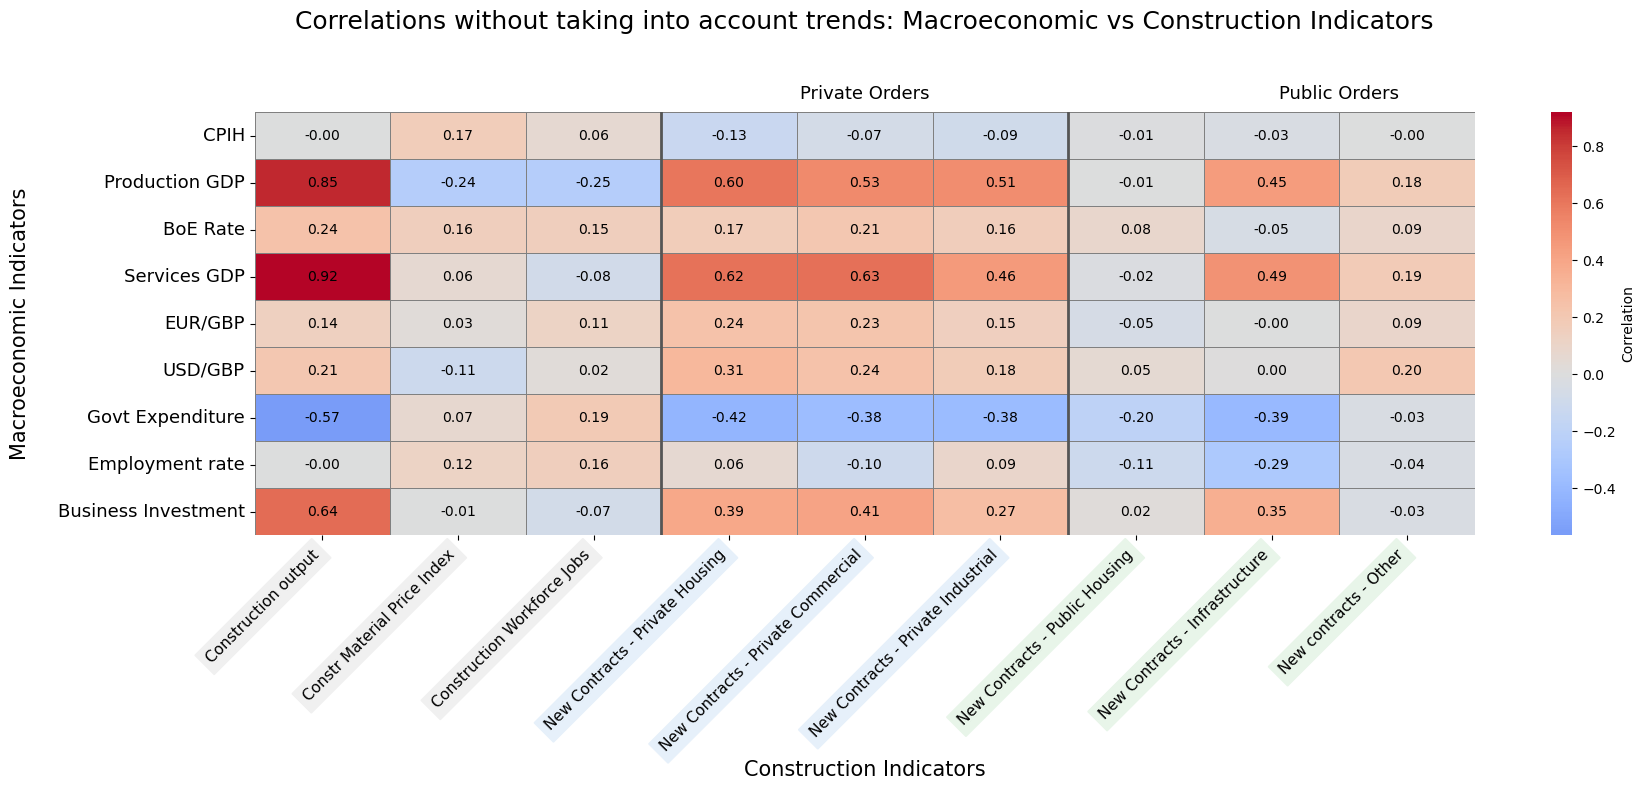

In [125]:
# Plot a heatmap for strong correlations
plot_correlation_heatmap(
    correlation_diff,
    title="Correlations without taking into account trends: Macroeconomic vs Construction Indicators",
)

#### 5.2 Correlations with taking trends into account

Seasonally adjusted log levels of the macro and construction series will be used to produce a levels (log) heat map. This view deliberately preserves long-run trends so potential cointegrating relationships can be screened visually before formal unit-root and Engle-Granger tests; normalization/standardization isn’t needed because correlation is scale-invariant.

In [126]:
#Check the columns list in the quarterly dataset
df_q_raw.columns

Index(['CPIH', 'Production GDP', 'Services GDP', 'Employment rate, %',
       'BoE Rate, %', 'EUR/GBP', 'USD/GBP', 'Business Investment, % change',
       'Govt Expenditure, £m', 'Construction output',
       'New Contracts - Public Housing', 'New Contracts - Private Housing',
       'New Contracts - Infrastructure', 'New contracts - Other',
       'New Contracts - Private Industrial',
       'New Contracts - Private Commercial', 'Workforce Jobs (thousands)'],
      dtype='object')

In [127]:
df_q_raw_add.columns

Index(['Constr Material Price Index', 'Small construction companies',
       'Medium construction companies', 'Large construction companies',
       'Number of all construction companies',
       'Employees - Small construction companies',
       'Employees - Medium construction companies',
       'Employees - Large construction companies',
       'Employees - All construction companies'],
      dtype='object')

In [128]:
# Preparing data: log levels, asinh transform
df_q_lvl = df_q_raw.drop(columns =['Govt Expenditure, £m', 'Employment rate, %', 'BoE Rate, %', 'Business Investment, % change'])

# Building a chain index from QoQ % change (quarterly) for 'Business Investment, % change'
bi_qoq = pd.to_numeric(df_q_raw['Business Investment, % change'], errors='coerce') / 100.0
# chain to an index (base = 100 at first valid quarter)
bi_idx = (1.0 + bi_qoq).cumprod()
bi_idx.iloc[0] = 1.0  # set base for the first valid row
bi_idx = (bi_idx * 100).rename('Business Investment')

# log levels
df_q_lvl = pd.concat([bi_idx, df_q_lvl, df_q_raw_add['Constr Material Price Index']],  axis=1, join='inner')
df_q_lvl = np.log(df_q_lvl).dropna()

# Sign-crossing level for Govt Expenditure as it’s not always >0
df_q_lvl = df_q_lvl.join(np.arcsinh(df_q_raw['Govt Expenditure, £m']).rename('Govt Expenditure'))
print(df_q_lvl.columns)
df_q_lvl = df_q_lvl[['CPIH', 'Production GDP', 'Services GDP', 
                     'EUR/GBP', 'USD/GBP', 'Business Investment', 'Govt Expenditure',
                     'Construction output', 'Constr Material Price Index', 'Workforce Jobs (thousands)',
                     'New Contracts - Private Housing', 'New Contracts - Private Commercial', 'New Contracts - Private Industrial',
                     'New Contracts - Public Housing', 'New Contracts - Infrastructure', 'New contracts - Other',
                    ]]

Index(['Business Investment', 'CPIH', 'Production GDP', 'Services GDP',
       'EUR/GBP', 'USD/GBP', 'Construction output',
       'New Contracts - Public Housing', 'New Contracts - Private Housing',
       'New Contracts - Infrastructure', 'New contracts - Other',
       'New Contracts - Private Industrial',
       'New Contracts - Private Commercial', 'Workforce Jobs (thousands)',
       'Constr Material Price Index', 'Govt Expenditure'],
      dtype='object')


In [129]:
#1. Define column groups
macro_cols = df_q_lvl.columns[:7]
construction_cols = df_q_lvl.columns[7:16]

#2. Compute 9x9 correlation matrix
correlation_lvl = pd.DataFrame(index=macro_cols, columns=construction_cols)

for macro in macro_cols:
    for constr in construction_cols:
        correlation_lvl.loc[macro, constr] = df_q_lvl[macro].corr(df_q_lvl[constr])

correlation_lvl = correlation_lvl.astype(float)

#3. Clean axis names
correlation_lvl.columns = [
    'Construction output',
    'Constr Material Price Index', 'Construction Workforce Jobs',
    'New Contracts - Private Housing', 'New Contracts - Private Commercial',
    'New Contracts - Private Industrial', 'New Contracts - Public Housing',
    'New Contracts - Infrastructure', 'New contracts - Other'
]

#4. Define group info
group_boundaries = [3, 6, 10]
group_ranges = [(0, 3), (3, 6), (6, 10), (10, 17)]
group_colors = ['#F0F0F0', '#E6F0FA', '#E8F5E9', '#FFF3E0']
group_labels = ['Private Orders', 'Public Orders']
group_label_ranges = [(3, 6), (6, 10), (10, 17)]


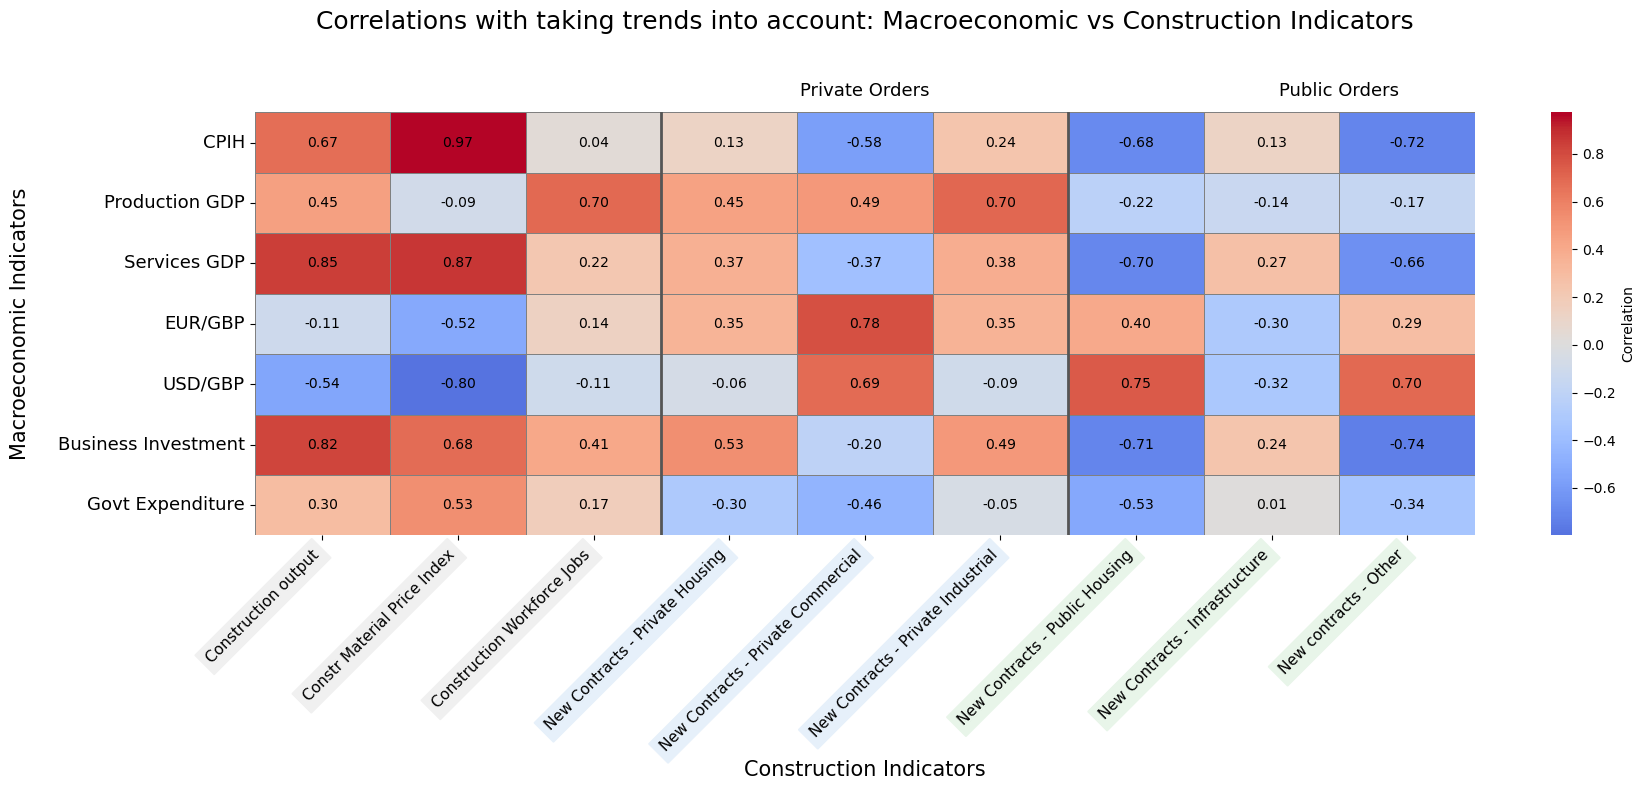

In [130]:
# Plot a heatmap for strong correlations
plot_correlation_heatmap(
    correlation_lvl,
    title="Correlations with taking trends into account: Macroeconomic vs Construction Indicators",
)

### Correlation Insights

Levels (log) heat map (trends kept): Broad, strong correlations, especially CPIH & Materials (≈0.97) and Services GDP & Construction output (≈0.85), signal common trend/price-level co-movement. FX shows USD/GBP negative with Materials but positive with private/commercial and public/housing orders, consistent with import costs vs export competitiveness. 
The levels heat map will used only to shortlist long-run (cointegration) candidates (e.g., GDP, CPIH, Materials with output).

Differenced (stationary) heat map (trends removed): Most large numbers collapse toward zero, leaving the genuine short-run links: GDP & Construction output/orders remain high (≈0.6-0.9), while CPIH, BoE rate, employment show weak or inconsistent contemporaneous effects. Govt spend is modestly negative for private orders and near-flat for public.

### 6. Analyzing Individual Indicators Patterns Using Visualization

#### 6.1 UK Economic Trends with Key Events

Before analyzing construction indicators, let's familiarize yourself with UK macroeconomic trends and key events.

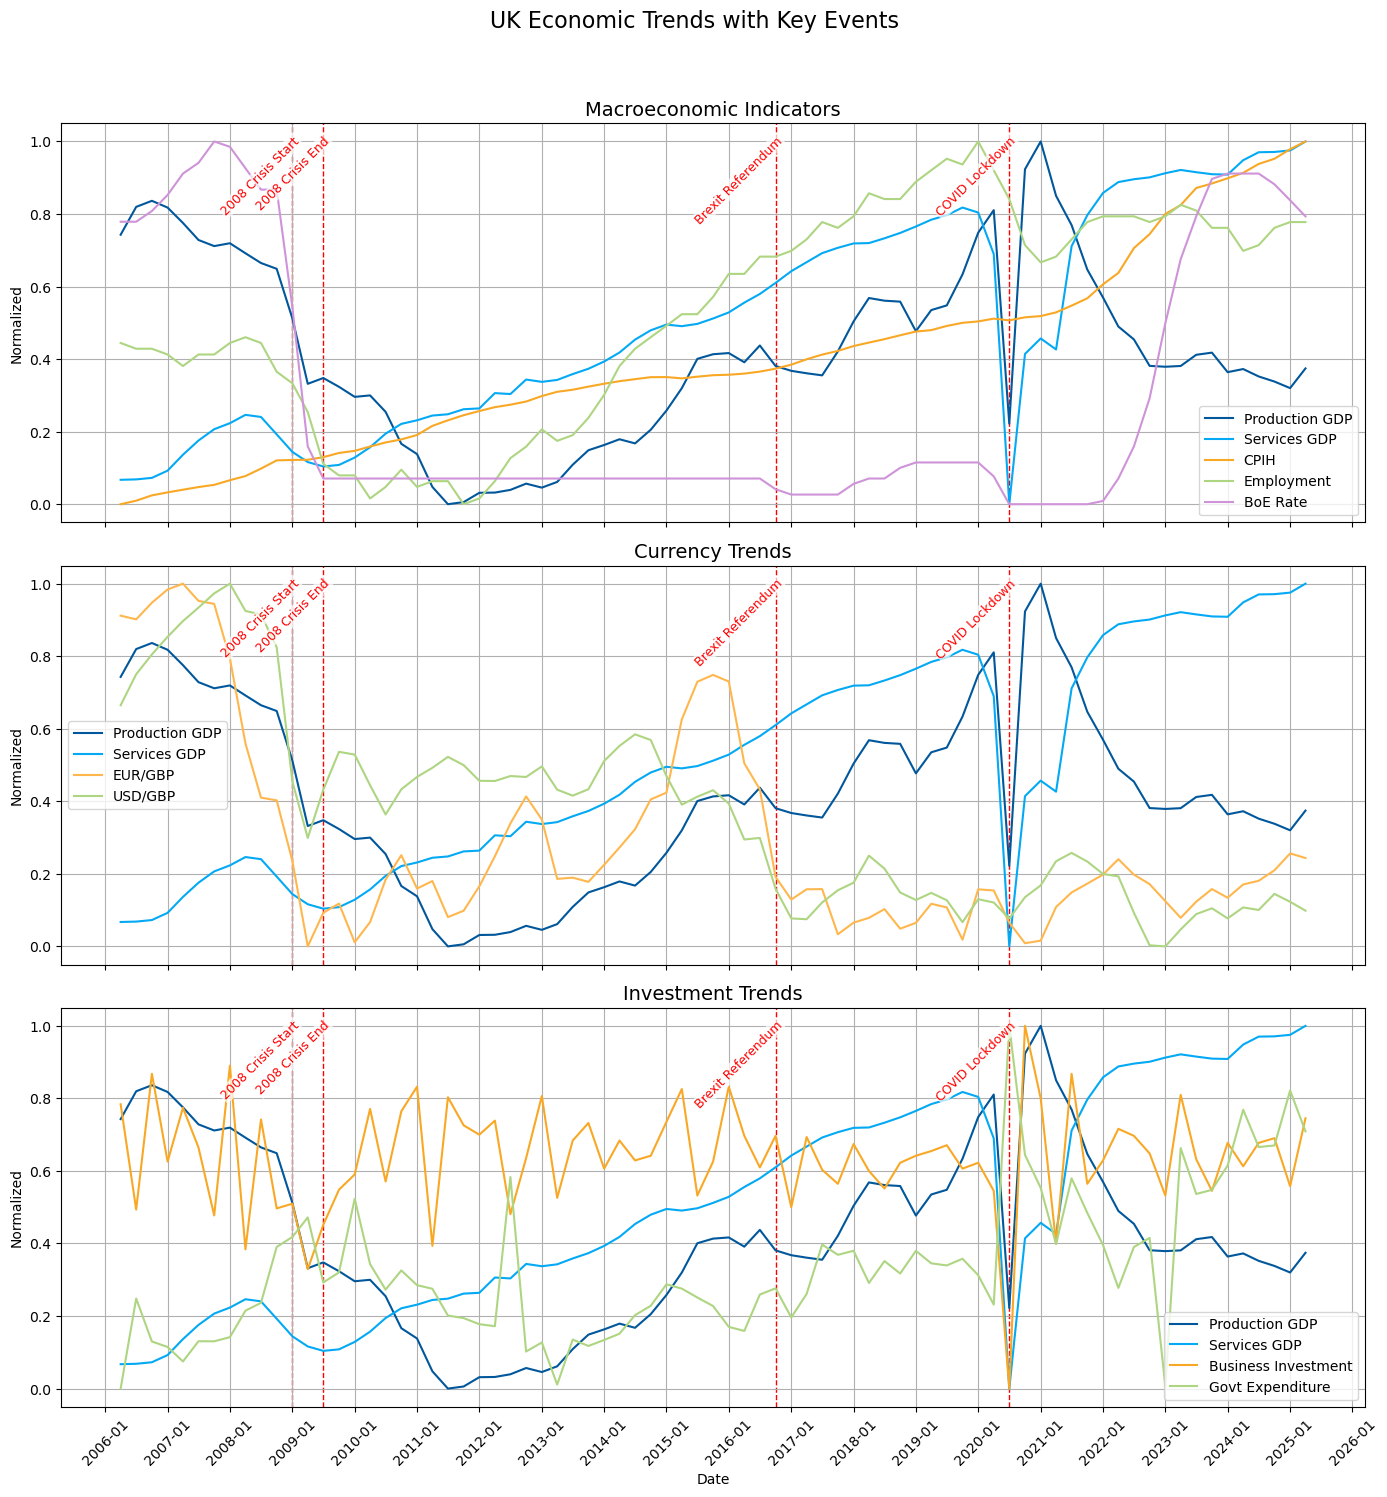

In [131]:
# Creating subplots for UK Economic Trends with Key Events using auxiliary function
plots_dict = {
    "Macroeconomic Indicators": [
        ['Production GDP', 'Services GDP', 'CPIH', 'Employment rate, %', 'BoE Rate, %'],
        ['Production GDP', 'Services GDP', 'CPIH', 'Employment', 'BoE Rate'],
        ['#01579B', '#03A9F4', '#f9a825', '#aed581', '#ce93d8']
    ],
    "Currency Trends": [
        ['Production GDP', 'Services GDP', 'EUR/GBP', 'USD/GBP'],
        ['Production GDP', 'Services GDP', 'EUR/GBP', 'USD/GBP'],
        ['#01579B', '#03A9F4', '#ffb74d', '#aed581']
    ],
    "Investment Trends": [
        ['Production GDP', 'Services GDP', 'Business Investment, % change', 'Govt Expenditure, £m'],
        ['Production GDP', 'Services GDP', 'Business Investment', 'Govt Expenditure'],
        ['#01579B', '#03A9F4', '#f9a825', '#aed581']
    ]
}

create_subplot_trends(df_q_norm, plots_dict, subtitle="UK Economic Trends with Key Events")

- The 2008 financial crisis and the COVID-19 lockdown caused significant declines in UK GDP, as seen across all three subplots. While the 2008 recovery was gradual, GDP rebounded quickly after the initial COVID shock, reflecting strong short-term resilience.

- CPIH remained relatively stable throughout most major events, suggesting inflation was not immediately driven by these crises, though longer-term pressures may have developed.

- The employment rate dropped sharply during the COVID-19 period, revealing the labor market’s sensitivity to abrupt shocks. However, its movement during the 2008 crisis was more gradual.

- BoE interest rates were slashed during both the 2008 and COVID-19 periods, highlighting the central bank’s use of monetary policy to stabilize the economy.

- Currency depreciation following the Brexit referendum and during the COVID crisis indicates reduced investor confidence. This has implications for import costs and inflation over time.

- Business investment showed a consistent pattern of decline during crisis periods, while government expenditure increased most significantly in response to COVID-19 — underscoring the state’s role in stabilizing the economy.

- Overall, the data reveal a pattern of economic vulnerability to shocks, followed by varying recovery speeds depending on the nature of the event and the policy response.

#### 6.2 Trends in UK Construction Output and Materials Prices

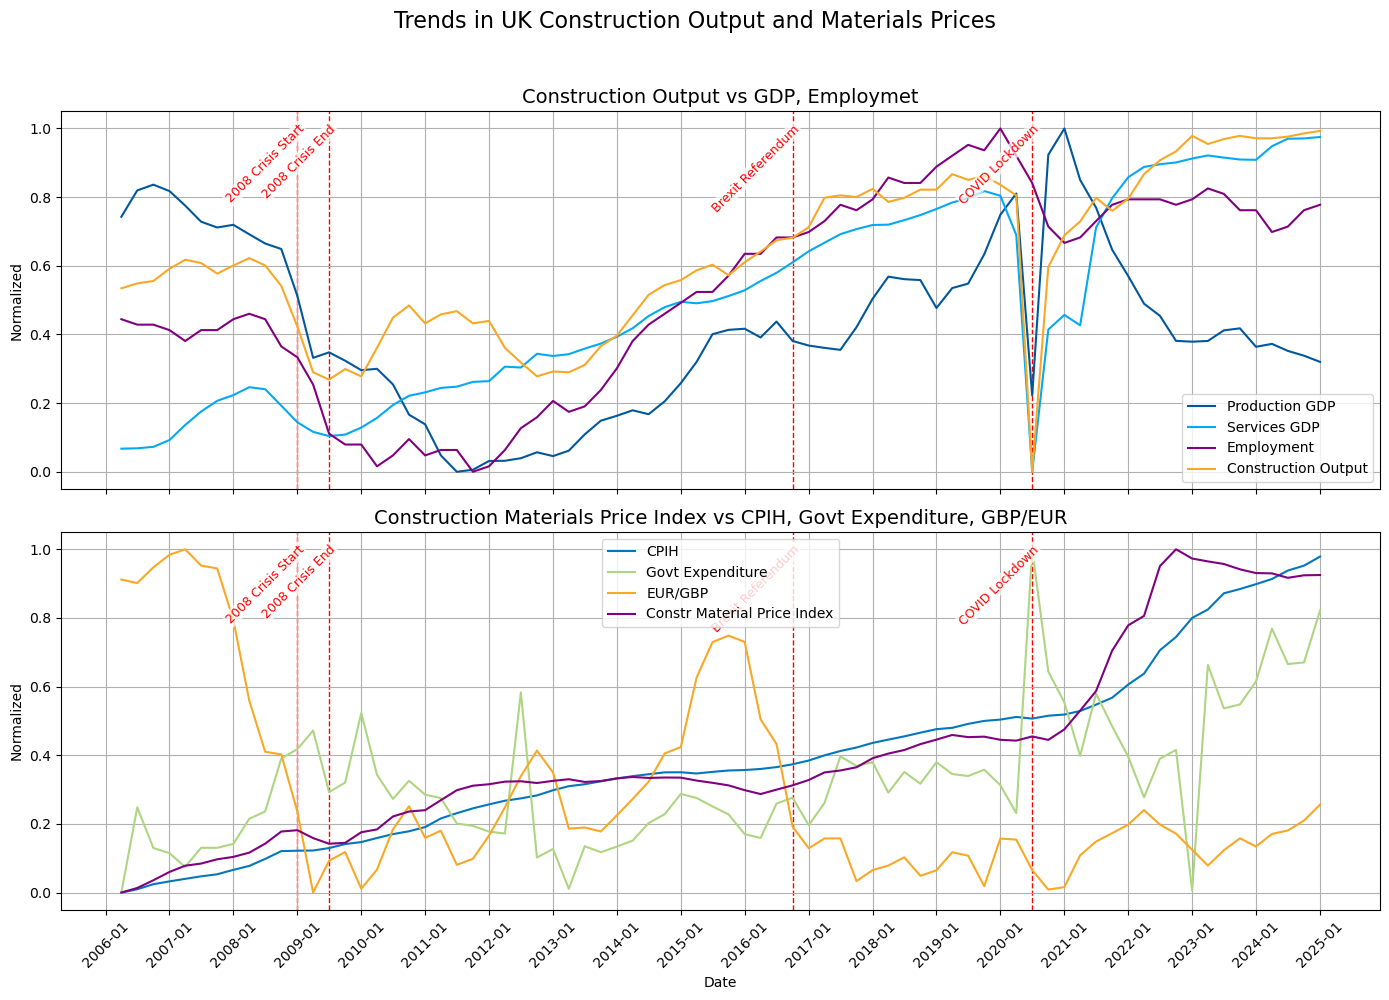

In [132]:
# Creating subplots for Trends in UK Construction Output and Materials Prices using auxiliary function
plots_dict = {
    "Construction Output vs GDP, Employmet": 
    [
        ['Production GDP', 'Services GDP', 'Employment rate, %', 'Construction output', 'CPIH'], 
        ['Production GDP', 'Services GDP', 'Employment', 'Construction Output', 'CPIH'],
        ['#01579B', '#03A9F4', 'purple', '#f9a825']
    ],
        "Construction Materials Price Index vs CPIH, Govt Expenditure, GBP/EUR": 
    [
        ['CPIH', 'Govt Expenditure, £m', 'EUR/GBP', 'Constr Material Price Index'], 
        ['CPIH', 'Govt Expenditure', 'EUR/GBP', 'Constr Material Price Index'],
        ['#0277bd', '#aed581', '#f9a825', 'purple']
    ]
}

create_subplot_trends(pd.concat([df_q_norm, df_q_norm_add], axis=1, join='inner'), plots_dict, subtitle="Trends in UK Construction Output and Materials Prices")

- Construction Output and GDP
  Convergence: Still evident — both plummet during 2008 crisis and COVID lockdown.
  Divergence: GDP lags slightly behind construction output post-2021.

- Material Prices and Currency (GBP/EUR)
  Convergence: Sharp material price increase post-Brexit, aligned with GBP depreciation.
  Divergence: In the 2022–2025 period, GBP/EUR stabilizes, but material prices remain elevated, implying additional inflationary pressures or supply constraints.

- Employment and Construction Output
  Convergence: Both fall during crises.
  Divergence: Post-2020, construction output recovers faster than employment, again suggesting labor market rigidities or mismatch.

- Govt Expenditure and Construction Output
  Convergence: Especially around 2020, surge in public spending seems followed by construction output rebound.
  Implication: Fiscal stimulus played a direct role in sectoral recovery.

- Interest Rates and Construction Output
  Historically aligned — output tends to increase after interest rate cuts, particularly visible after 2008 and 2020.

#### 6.2 Construction firms and economic trends

Small comapnies make up 99% of all construction companies, normalized data will be used to compare trends.

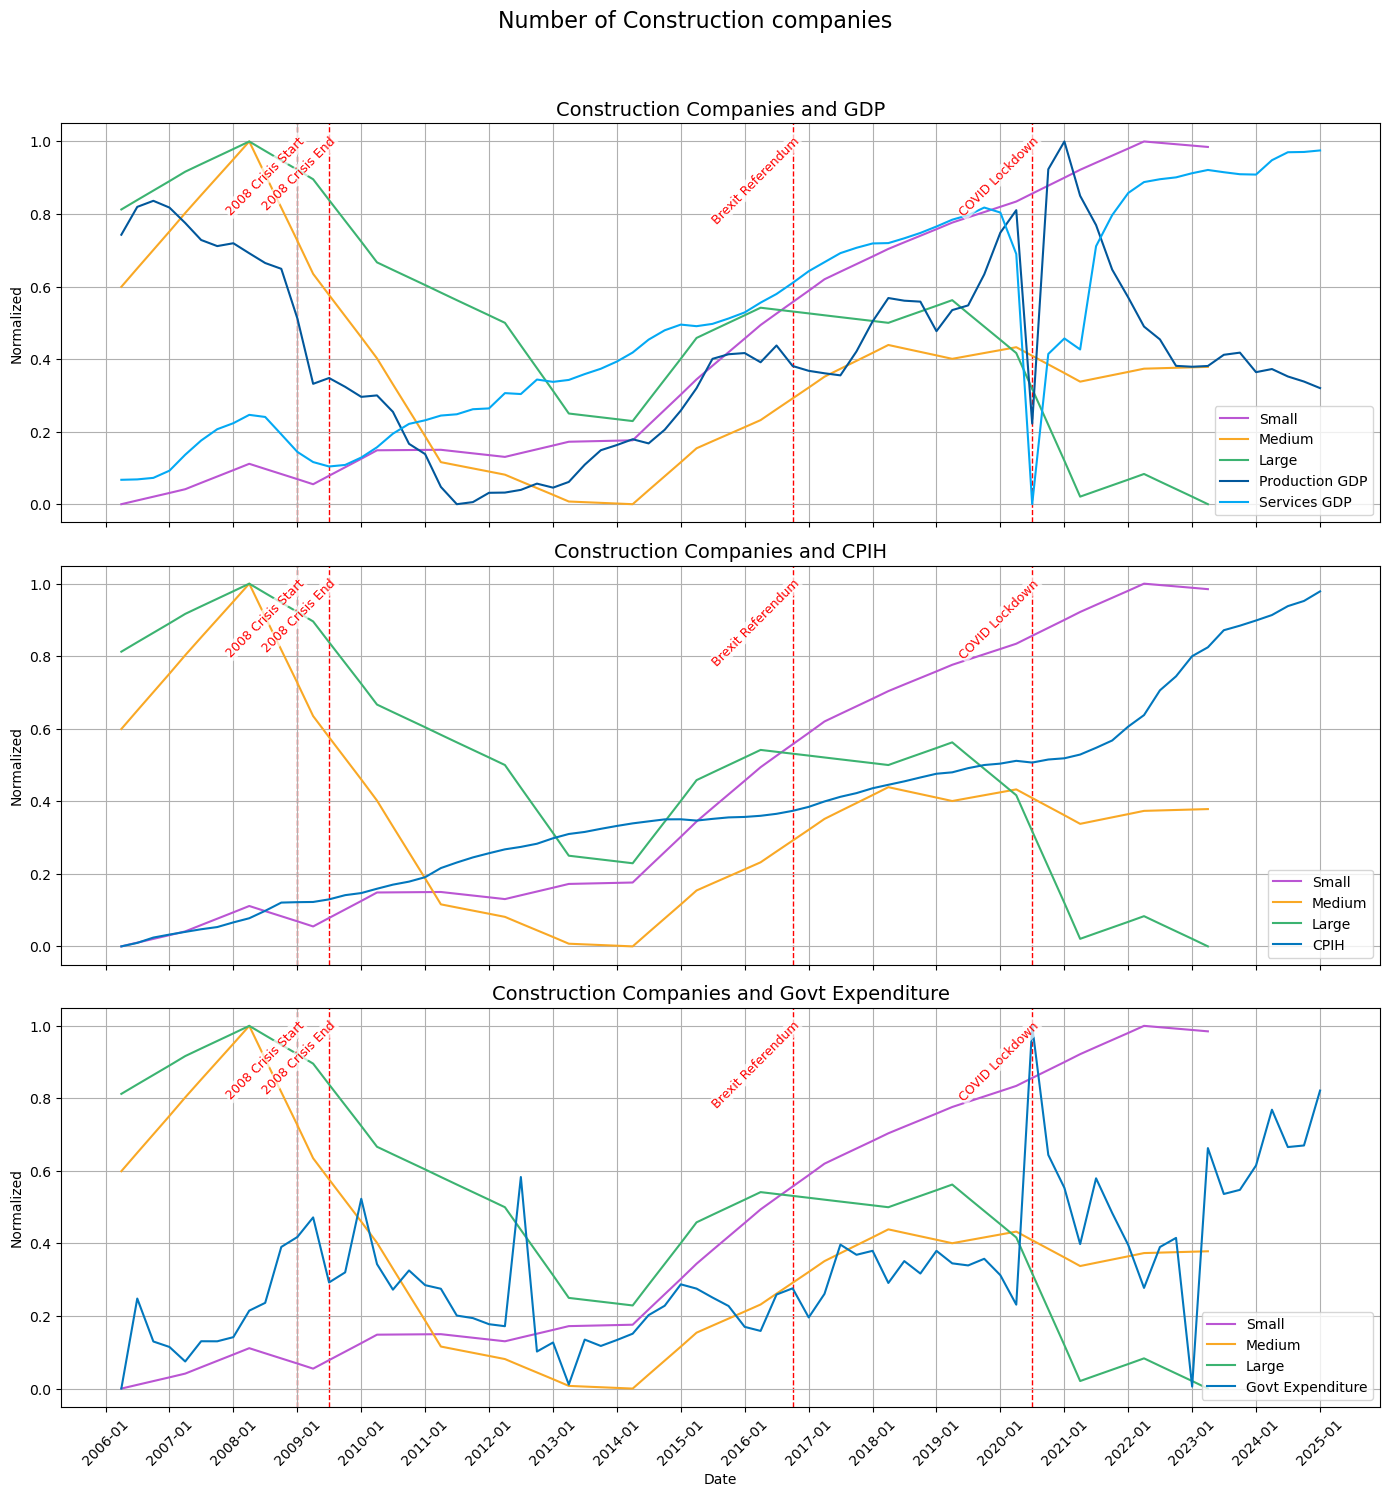

In [133]:
# Creating subplots for number of construction companies changes over time and Key economic Events
plots_dict = {
    "Construction Companies and GDP": [
        ['Small construction companies', 'Medium construction companies', 'Large construction companies', 'Production GDP', 'Services GDP'],
        ['Small', 'Medium', 'Large', 'Production GDP', 'Services GDP'],
        ['#BA55D3', '#f9a825', '#3CB371', '#01579B', '#03A9F4']
    ],
    "Construction Companies and CPIH": [
        ['Small construction companies', 'Medium construction companies', 'Large construction companies', 'CPIH'],
        ['Small', 'Medium', 'Large', 'CPIH'],
        ['#BA55D3', '#f9a825', '#3CB371', '#0277bd']
    ],
    "Construction Companies and Govt Expenditure": [
        ['Small construction companies', 'Medium construction companies', 'Large construction companies', 'Govt Expenditure, £m'],
        ['Small', 'Medium', 'Large', 'Govt Expenditure'],
        ['#BA55D3', '#f9a825', '#3CB371', '#0277bd']
    ]
}

create_subplot_trends(pd.concat([df_q_norm, df_q_norm_add], axis=1, join='inner'), plots_dict, subtitle="Number of Construction companies")

**2008 Financial Crisis Impact**

- Small, medium, and large construction companies show stagnation or decline during the crisis.
- Post-crisis, small companies recover more visibly, while large firms decline gradually.

**Post-Brexit Divergence with CPIH**

- After the 2016 Brexit referendum, CPIH rises steadily.
- In contrast, the number of construction companies—especially medium and large—plateaus or decreases, implying inflation outpaces industry expansion.

**COVID-19 Lockdown Effects**

- Large construction companies decline sharply during early 2020, while small companies remain stable or even grow, suggesting smaller firms may have been more adaptable or less exposed
- Government expenditure spikes, suggesting stimulus support not immediately mirrored in firm recovery.

**Post-COVID Recovery and Resilience**

- Small companies show stable grow.
- Medium companies show slow recovery.
- Large firms show an attempt to recovery in 2022 but then continue to decline, indicating weaker resilience.

**2008 Crisis as a Converging Event**

- Small companies show quick recovery
- Medium and large companies continue to decline even after financial market recovery

**Divergence During Brexit and COVID**

- Government expenditure increases, while company counts stagnate or fall, indicating policy focus on macro-stabilization over direct industry stimulus.


#### 6.3 Employment trends in the UK construction industry

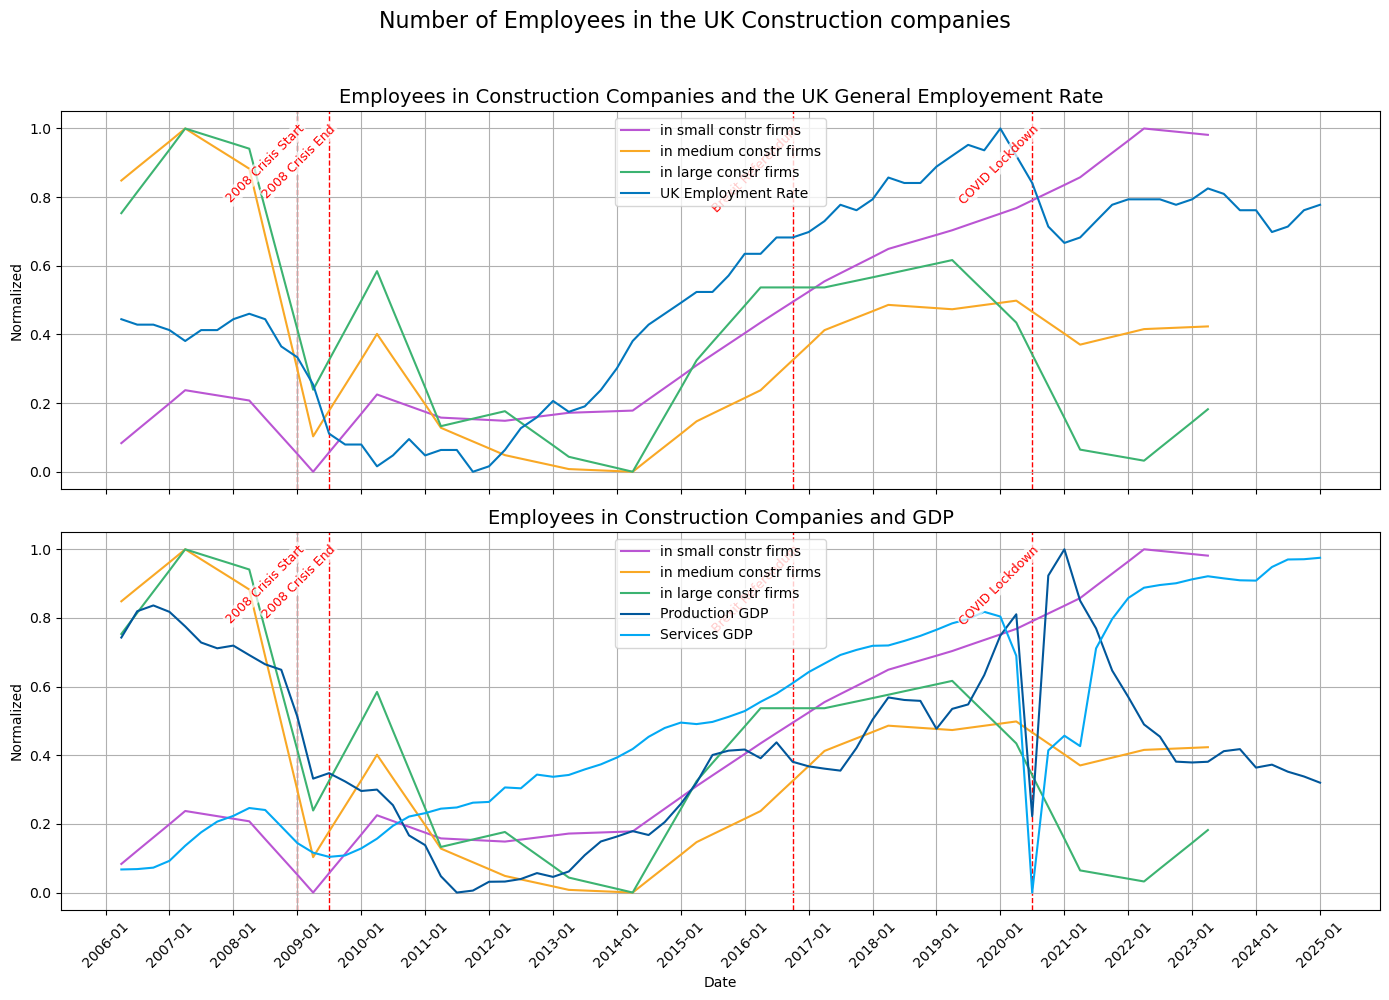

In [134]:
# Creating subplots for number of employees in construction companies over time and Key economic Events
plots_dict = {
    "Employees in Construction Companies and the UK General Employement Rate": [
        ['Employees - Small construction companies', 'Employees - Medium construction companies', 'Employees - Large construction companies', 'Employment rate, %'],
        ['in small constr firms ', 'in medium constr firms', 'in large constr firms', 'UK Employment Rate'],
        ['#BA55D3', '#f9a825', '#3CB371', '#0277bd']
    ],
    "Employees in Construction Companies and GDP": [
        ['Employees - Small construction companies', 'Employees - Medium construction companies', 'Employees - Large construction companies', 'Production GDP', 'Services GDP'],
        ['in small constr firms ', 'in medium constr firms', 'in large constr firms', 'Production GDP', 'Services GDP'],
        ['#BA55D3', '#f9a825', '#3CB371', '#01579B', '#03A9F4']
    ]
}

create_subplot_trends(pd.concat([df_q_norm, df_q_norm_add], axis=1, join='inner'), plots_dict, subtitle="Number of Employees in the UK Construction companies")

- During the 2008 Financial Crisis, employment across all construction firm sizes declines significantly, with large firms dropping most sharply, suggesting their higher exposure to systemic shocks.

- The UK Employment Rate also drops during the crisis, but starts recovering post-2011, unlike construction employment, which remains subdued longer—indicating a slower recovery for the construction sector than the general labor market.

- Post-2010, employment in small firms gradually rises and becomes the leading contributor by 2020, indicating the growing importance of small firms in construction employment.

- Medium-sized firms show a plateau post-crisis and remain relatively stable until 2020, after which they stagnate—pointing to a lack of growth momentum in the medium segment.

- Employment in large construction firms remains volatile and does not recover to pre-crisis levels, especially post-2016, showing possible downsizing or structural shifts.

- Brexit (2016) seems to have minimal immediate impact on overall employment levels in construction firms, but a slight slowing in upward trends is noticeable.

- The COVID-19 Lockdown (2020) causes a noticeable dip in UK GDP and Employment Rate, but small construction firm employment levels appear largely unaffected. Medium ad Large firms employment show significant decline which was not fully restored.

- Post-COVID, employment in small construction firms continues to rise, reflecting a shift in sector dynamics where smaller firms are becoming key employers.

- The alignment between GDP and construction employment is more consistent than with the UK-wide employment rate, especially in the recovery phase—hinting that construction employment may track economic output more closely than general labor trends.

#### 6.4 New contracts trends in the UK construction industry
Before analyzing new contracts trends over time, let's familiarize yourself with each subsector percetage of all new contracts on 2025-01-01 .

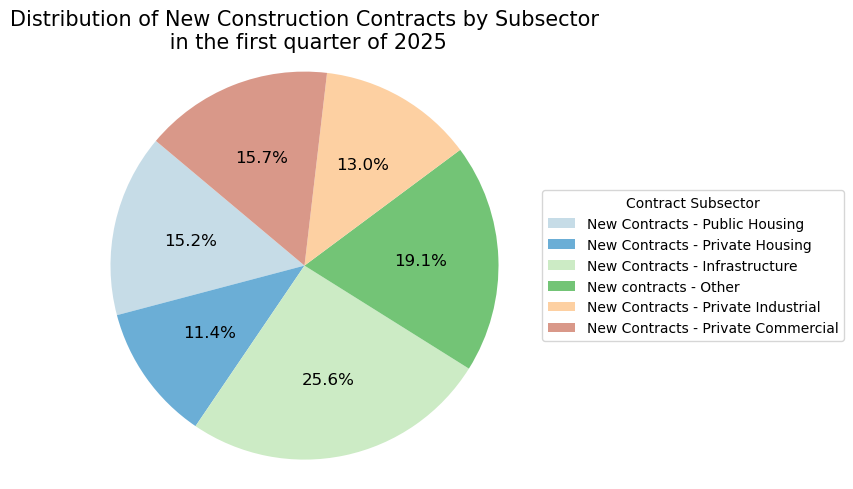

In [135]:
# Filter the quaerter for the specific date
target_Q = '2025Q1'
row = df_q_raw.loc[target_Q, ['New Contracts - Public Housing',
       'New Contracts - Private Housing',
       'New Contracts - Infrastructure', 'New contracts - Other',
       'New Contracts - Private Industrial',
       'New Contracts - Private Commercial']]

# Define better-separated colors (6 distinct ones)
colors = [
    '#c6dce7',  # soft light blue
    '#6baed6',  # muted blue
    '#ccebc5',  # soft green
    '#73c476',  # muted green
    '#fdd0a2',  # peachy orange
    '#d99889'   # dusty red (less bright)
]

# Plot
plt.figure(figsize=(8, 5))
wedges, texts, autotexts = plt.pie(
    row,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'color': 'black', 'fontsize': 12}
)
plt.legend(row.index, title='Contract Subsector', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.title('Distribution of New Construction Contracts by Subsector\n in the first quarter of 2025', fontsize=15, pad=1)
plt.axis('equal')

plt.tight_layout()
plt.show()

In [136]:
print(df_q_norm.columns)
print(df_q_norm_add.columns)

Index(['CPIH', 'Production GDP', 'Services GDP', 'Employment rate, %',
       'BoE Rate, %', 'EUR/GBP', 'USD/GBP', 'Business Investment, % change',
       'Govt Expenditure, £m', 'Construction output',
       'New Contracts - Public Housing', 'New Contracts - Private Housing',
       'New Contracts - Infrastructure', 'New contracts - Other',
       'New Contracts - Private Industrial',
       'New Contracts - Private Commercial', 'Workforce Jobs (thousands)',
       'GFC', 'HS2', 'COVID lockdown', 'Brexit'],
      dtype='object')
Index(['Constr Material Price Index', 'Small construction companies',
       'Medium construction companies', 'Large construction companies',
       'Number of all construction companies',
       'Employees - Small construction companies',
       'Employees - Medium construction companies',
       'Employees - Large construction companies',
       'Employees - All construction companies'],
      dtype='object')


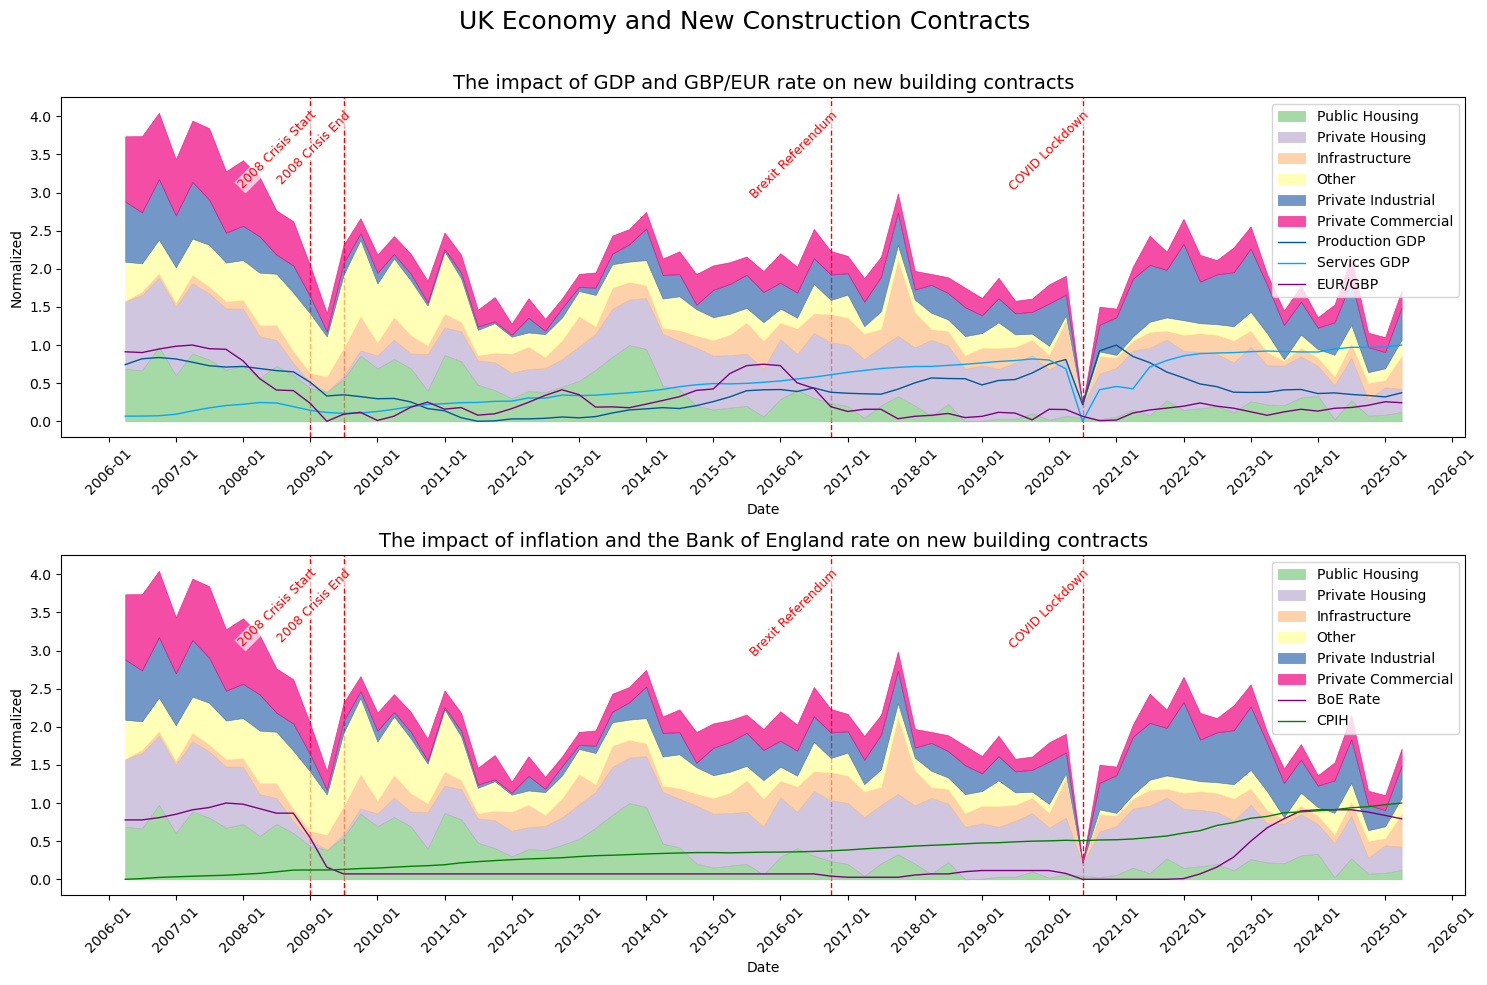

In [137]:
plots_dict = {
    'The impact of GDP and GBP/EUR rate on new building contracts':
    [
        df_q_norm,
        [
            'New Contracts - Public Housing',
           'New Contracts - Private Housing',
           'New Contracts - Infrastructure', 
            'New contracts - Other',
           'New Contracts - Private Industrial',
           'New Contracts - Private Commercial'
        ], 
        [
            'Public Housing',
           'Private Housing',
           'Infrastructure', 
            'Other',
           'Private Industrial',
           'Private Commercial'
        ],
        ['Production GDP', 'Services GDP', 'EUR/GBP'], ['Production GDP', 'Services GDP', 'EUR/GBP'], ['#01579B', '#03A9F4', 'purple']
    ],
    'The impact of inflation and the Bank of England rate on new building contracts':
    [
        df_q_norm,
        [
            'New Contracts - Public Housing',
           'New Contracts - Private Housing',
           'New Contracts - Infrastructure', 
            'New contracts - Other',
           'New Contracts - Private Industrial',
           'New Contracts - Private Commercial'
        ], 
        [
            'Public Housing',
           'Private Housing',
           'Infrastructure', 
            'Other',
           'Private Industrial',
           'Private Commercial'
        ],
        ['BoE Rate, %', 'CPIH'], ['BoE Rate', 'CPIH'], ['purple', 'green']
    ]
}

create_subplot_new_contr(plots_dict, subtitle = 'UK Economy and New Construction Contracts')

- During the 2008 financial crisis, new construction contracts across all sectors (public housing, private housing, infrastructure, etc.) dropped sharply, converging with a decline in GDP and GBP/EUR, reflecting a broad economic downturn.

- The Brexit referendum (2016) saw a temporary dip in contracts, converging with GBP/EUR decline, suggesting currency volatility impacted construction activity.

- Post-Brexit, infrastructure and other contracts diverged upward while GDP and CPIH remained stable, likely due to government stimulus or long-term project continuity.

- During the COVID-19 lockdown (2020), all contract types plummeted, converging with a GDP drop, indicating a widespread economic halt.
Post-lockdown, private housing and commercial contracts recovered more quickly, diverging from CPIH and GBP/EUR, possibly due to pent-up demand and policy support.

- Public housing contracts show a steady but lower trend, diverging from private sectors, which may reflect limited public funding compared to private investment.

- Overall, economic events drive convergence during downturns and divergence during recoveries, influenced by sector-specific resilience and policy responses.

## Time-Lag Insights: Macroeconomic Indicators and UK Construction Sector Trends

| Macroeconomic Indicator | Construction Indicator | Typical Lag Time | Notes on Observations and Events |
|------------------------|-----------------------|------------------|----------------------------------|
| GDP | Construction Output | 3–6 months | - During downturns (e.g., 2008 financial crisis, COVID-19), GDP declines precede construction output drops by 3–6 months, as seen in EDA subplots. <br> - **Post-2021 Exception**: Construction output led GDP recovery, likely due to stimulus or anticipatory investments, indicating a reverse lag. |
| CPIH (Inflation) | Construction Material Prices | 3–12 months | - CPIH increases lead material price hikes, with delays from supply chain adjustments, observed in the material prices subplot. <br> - Post-Brexit, prices remained elevated beyond CPIH stabilization, suggesting external pressures. |
| Employment Rate | Construction Employment | 6–12 months | - General employment rate declines are followed by construction employment drops, with slower recovery, as shown in employment trends subplot. <br> - Reflects sector-specific labor market dynamics. |
| Economic Conditions (GDP, CPIH) | New Construction Contracts | 6–12 months | - New contracts decline during shocks (e.g., COVID-19) and recover post-stabilization, per the new contracts subplot. <br> - Delays stem from project planning and financing timelines. |
| Currency (GBP/EUR, GBP/USD) | Construction Material Prices | 1–3 months | - Currency depreciation (e.g., post-Brexit, COVID-19) rapidly increases material prices due to import costs, as seen in currency and material prices subplots. |
| Currency (GBP/EUR, GBP/USD) | New Construction Contracts | 3–6 months | - Exchange rate shifts affect new contracts, particularly private commercial ones tied to foreign investment, per currency and contracts subplots. <br> - Investment decisions adjust more slowly. |

### Key Takeaways
- **Lag Range**: Time-lags span **1–12 months**, reflecting the construction sector’s delayed response to economic changes.
- **GDP and Output**: Typically a 3–6 month lag, with a notable post-2021 reversal where construction led GDP.
- **CPIH and Material Prices**: Inflation drives prices with a 3–12 month delay, amplified by Brexit effects.
- **Employment**: Construction employment lags broader trends by 6–12 months, recovering slowly.
- **New Contracts**: Economic conditions impact contracts with a 6–12 month delay due to planning.
- **Currency Effects**: Material prices react quickly (1–3 months) to currency changes, while contracts lag by 3–6 months.

These findings, grounded in the EDA’s visual analysis, support the development of time-lagged predictive models (e.g., VAR) for forecasting construction trends.

## Conclusion

The Exploratory Data Analysis (EDA) of the UK construction sector (2006–2025) revealed strong correlations between macroeconomic indicators and construction metrics, with GDP (0.92) and employment rate (0.79) driving output, and CPIH (0.97) and government expenditure (0.94) influencing material prices. Visual trends highlighted the sector’s sensitivity to economic shocks (e.g., 2008 crisis, COVID-19), with small firms showing resilience and material prices spiking post-Brexit. Time-lags of 1–12 months (e.g., 3–6 months for GDP to output, 1–3 months for currency to material prices) underscore delayed responses, informing predictive modeling and policy analysis.

### Authors

[Alisa Makhonina](https://www.linkedin.com/in/alisa-makhonina-data-science/) Data scientist with over 8 years of experience in construction cost engineering. Structural Engineering graduate.